# Classificação de Imagens Histopatológicas utilizando Transfer Learning com ResNet-50

Este projeto apresenta o desenvolvimento de um modelo de Deep Learning para a classificação de imagens histopatológicas de câncer de mama, com o objetivo de diferenciar lesões benignas e malignas do dataset público BreakHis.

A metodologia central é o Transfer Learning, que aproveita o aprendizado da arquitetura ResNet-50, pré-treinada no dataset ImageNet. O processo de treinamento é conduzido em duas fases estratégicas:

- Treinamento do Classificador: Inicialmente, apenas a camada de classificação final da rede é treinada, enquanto as camadas convolucionais (extratoras de características) permanecem "congeladas". Esta abordagem permite adaptar o modelo ao nosso problema de forma rápida e estável.
- Ajuste Fino (Fine-Tuning): Em seguida, toda a rede é "descongelada" e re-treinada com uma taxa de aprendizado muito baixa, permitindo um ajuste sutil dos pesos pré-treinados para especializar o modelo no domínio específico das imagens médicas.

O pipeline de dados inclui etapas de pré-processamento e Data Augmentation para aumentar a variabilidade dos dados e a robustez do modelo. A performance é avaliada em um conjunto de teste isolado, utilizando métricas como o relatório de classificação (precisão, recall, F1-score) e a matriz de confusão.

Ao final, o notebook entrega um modelo treinado, otimizado e avaliado, que é salvo em disco para futuras aplicações de inferência.

Importação das bibliotecas necessárias

In [25]:
import os
import random
import shutil
import time

import kagglehub
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from torch import Generator
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights, resnet50

## Etapa 0: Aquisição e Organização do Dataset

O objetivo desta etapa inicial é preparar o ambiente de trabalho, realizando o download do dataset BreakHis e reorganizando sua estrutura de arquivos para um formato adequado ao treinamento de modelos de deep learning.

Download do dataset BreakHis a partir do repositório do Kaggle utilizando a biblioteca kagglehub.

In [ ]:
caminho = kagglehub.dataset_download("ambarish/breakhis")

Abaixo, ocorre a definição das variáveis de caminho para o dataset de origem e para o diretório de destino, que será usado para organizar os dados. Em seguida, a estrutura de pastas de destino é criada, com subdiretórios separados para cada uma das classes do problema ("benign" e "malignant").

In [ ]:
caminho_dados = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
caminho_destino = '/kaggle/working/data'
classes = ['benign', 'malignant']

for classe in classes:
    os.makedirs(os.path.join(caminho_destino, classe), exist_ok=True)

Para simplificar a estrutura do dataset, é criada uma função que navega pela organização original de pastas, a qual é dividida por subtipo, paciente e magnificação. Esta função extrai apenas as imagens com magnificação de 40X, renomeia cada arquivo para garantir sua unicidade e os copia para os diretórios de destino (benign e malignant) previamente criados.

In [ ]:
def copiar_imagens(classe, magnificacao='40X'):
    caminho_dados_sob = os.path.join(caminho_dados, classe, 'SOB')
    caminho_destino_classe = os.path.join(caminho_destino, classe)

    dirs_subtipos = os.listdir(caminho_dados_sob)

    for subtipo in dirs_subtipos:
        caminho_subtipo = os.path.join(caminho_dados_sob, subtipo)

        dirs_pacientes = os.listdir(caminho_subtipo)
        for id_paciente in dirs_pacientes:
            caminho_mag = os.path.join(caminho_subtipo, id_paciente, magnificacao)

            if os.path.isdir(caminho_mag):
                imagens = [f for f in os.listdir(caminho_mag) if f.endswith('.png')]
                for nome_imagem in imagens:
                    arquivo_origem = os.path.join(caminho_mag, nome_imagem)
                    nome_imagem_destino = f"{id_paciente}-{subtipo}-{nome_imagem}"
                    arquivo_destino = os.path.join(caminho_destino_classe, nome_imagem_destino)
                    shutil.copy(arquivo_origem, arquivo_destino)

copiar_imagens('benign')
copiar_imagens('malignant')

## Etapa 1: Análise Básica do Dataset

Após a organização dos dados, é realizada uma breve análise básica para compreender as características fundamentais do dataset. Esta etapa verifica a quantidade total de imagens e a distribuição entre as classes (balanceamento), além de visualizar amostras aleatórias de cada categoria. Esse entendimento inicial é importante para contextualizar o problema e os resultados do modelo.

Total de imagens benignas: 625
Total de imagens malignas: 1370
Total de imagens no dataset: 1995



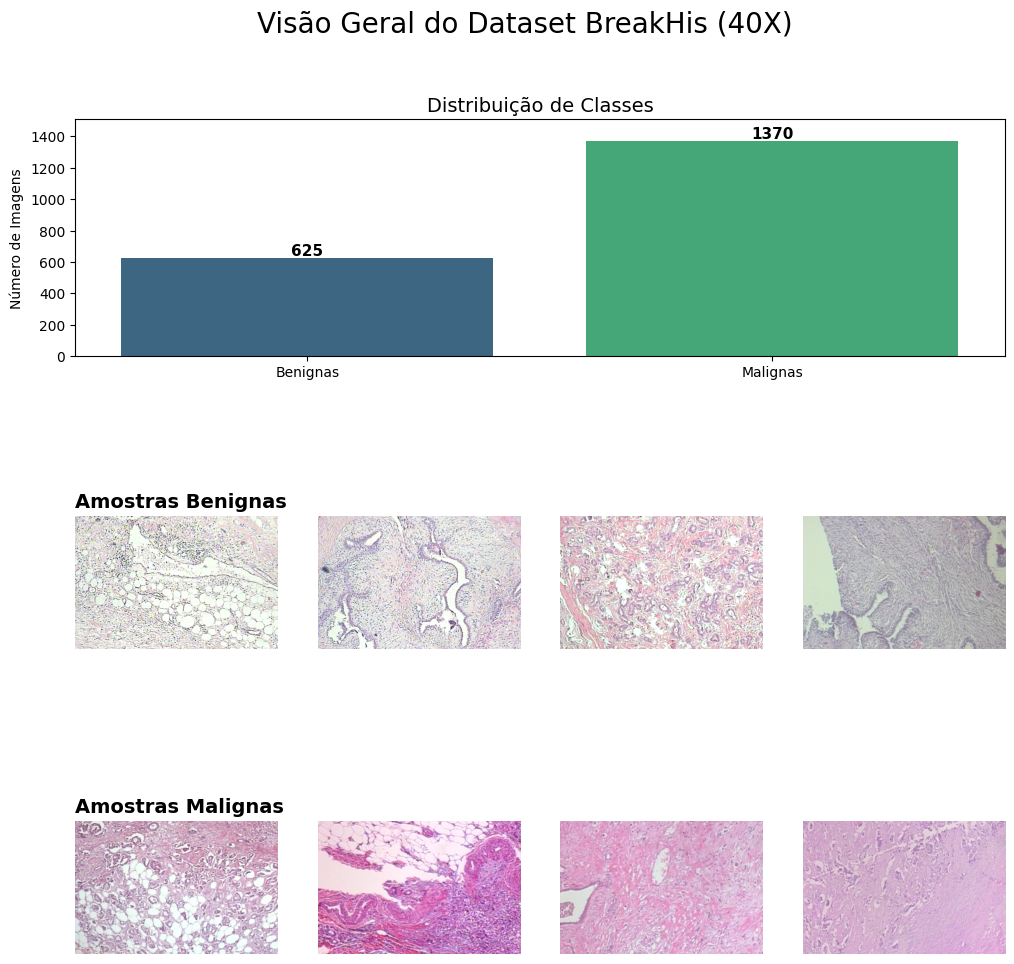

In [28]:
path_benign = os.path.join(caminho_destino, 'benign')
path_malignant = os.path.join(caminho_destino, 'malignant')

num_benign = len(os.listdir(path_benign))
num_malignant = len(os.listdir(path_malignant))
total_images = num_benign + num_malignant

print(f"Total de imagens benignas: {num_benign}")
print(f"Total de imagens malignas: {num_malignant}")
print(f"Total de imagens no dataset: {total_images}\n")

fig = plt.figure(figsize=(12, 11))
gs = gridspec.GridSpec(3, 4, figure=fig, height_ratios=[1.5, 1, 1], hspace=0.8)

fig.suptitle('Visão Geral do Dataset BreakHis (40X)', fontsize=20)

ax1 = fig.add_subplot(gs[0, :])
classes_nomes = ['Benignas', 'Malignas']
sns.barplot(x=classes_nomes, y=[num_benign, num_malignant], ax=ax1, palette='viridis', hue=classes_nomes, legend=False)
ax1.set_title('Distribuição de Classes', fontsize=14)
ax1.set_ylabel('Número de Imagens')
for index, value in enumerate([num_benign, num_malignant]):
    ax1.text(index, value, str(value), ha='center', va='bottom', fontsize=11, fontweight='bold')
max_val = max(num_benign, num_malignant)
ax1.set_ylim(top=max_val * 1.1)

benign_samples = random.sample(os.listdir(path_benign), 4)
for i, file in enumerate(benign_samples):
    ax = fig.add_subplot(gs[1, i])
    img = Image.open(os.path.join(path_benign, file))
    ax.imshow(img)
    ax.axis('off')

    if i == 0:
        ax.set_title('Amostras Benignas', loc='left', fontsize=14, fontweight='bold')

malignant_samples = random.sample(os.listdir(path_malignant), 4)
for i, file in enumerate(malignant_samples):
    ax = fig.add_subplot(gs[2, i])
    img = Image.open(os.path.join(path_malignant, file))
    ax.imshow(img)
    ax.axis('off')

    if i == 0:
        ax.set_title('Amostras Malignas', loc='left', fontsize=14, fontweight='bold')

plt.show()

## Etapa 2: Pré-processamento e Estruturação dos Dados

Nesta etapa, os dados de imagem, já organizados em pastas, são preparados para o treinamento do modelo. O processo envolve a configuração do ambiente, a definição de transformações de pré-processamento e a estruturação dos dados em lotes eficientes.

Início da configuração do modelo e dos dados. O device para o treinamento (GPU ou CPU) é selecionado automaticamente para garantir a otimização de performance. O tamanho de entrada das imagens é definido como 224x224 pixels, um requisito padrão para a arquitetura ResNet pré-treinada. Por fim, o conjunto de dados, já organizado em pastas de classe, é carregado usando a função ImageFolder do PyTorch.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TAMANHO_IMAGEM = 224
dataset_completo = datasets.ImageFolder(caminho_destino)

Definição de dois pipelines de transformações para o pré-processamento das imagens.

- train_transforms: Aplicado ao conjunto de treino, inclui técnicas de Data Augmentation como rotações, inversões e ajustes de cor aleatórios. Essas transformações aumentam a variabilidade dos dados e ajudam a prevenir o overfitting.

- val_test_transforms: Aplicado aos conjuntos de validação e teste, contém apenas as transformações essenciais (redimensionamento e normalização), garantindo uma avaliação consistente e reprodutível do modelo.

Ambos os pipelines convertem as imagens para tensores do PyTorch e as normalizam com os valores médios e de desvio padrão do dataset ImageNet, um pré-requisito para o uso de modelos pré-treinados.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((TAMANHO_IMAGEM, TAMANHO_IMAGEM)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((TAMANHO_IMAGEM, TAMANHO_IMAGEM)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

O dataset é dividido em três subconjuntos: treino (70%), validação (15%) e teste (15%). Para garantir a reprodutibilidade, a divisão aleatória dos índices é realizada com uma semente fixa.

Para aplicar as transformações de pré-processamento de forma independente, são criadas cópias do dataset original para cada subconjunto. O pipeline com Data Augmentation é atribuído ao conjunto de treino, enquanto os de validação e teste recebem o pipeline padrão.

Finalmente, são criados os DataLoaders para cada subconjunto, responsáveis por fornecer os dados ao modelo em lotes (batches). O DataLoader de treino é configurado para embaralhar os dados a cada época (shuffle=True), uma prática que melhora a generalização do modelo.

In [ ]:
generator = Generator().manual_seed(42)

train_size = int(0.7 * len(dataset_completo))
val_size = int(0.15 * len(dataset_completo))
test_size = len(dataset_completo) - train_size - val_size

train_subset, val_subset, test_subset = random_split(dataset_completo,
                                                     [train_size, val_size, test_size],
                                                     generator=generator)

train_dataset = datasets.ImageFolder(caminho_destino, transform=train_transforms)
val_test_dataset = datasets.ImageFolder(caminho_destino, transform=val_test_transforms)

generator = Generator().manual_seed(42)

total_len = len(train_dataset)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)
test_size = total_len - train_size - val_size

train_subset, _, _ = random_split(train_dataset, [train_size, val_size + test_size, 0], generator=generator)
_, val_subset, test_subset = random_split(val_test_dataset, [train_size, val_size, test_size], generator=generator)

tamanho_batch = 32
train_loader = DataLoader(train_subset, batch_size=tamanho_batch, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=tamanho_batch, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=tamanho_batch, shuffle=False)

nomes_classes = dataset_completo.classes
print(f"Classes: {nomes_classes}")
print(f"Tamanho do conjunto de Treino: {len(train_subset)}")
print(f"Tamanho do conjunto de Validação: {len(val_subset)}")
print(f"Tamanho do conjunto de Teste: {len(test_subset)}")

Classes: ['benign', 'malignant']
Tamanho do conjunto de Treino: 1396
Tamanho do conjunto de Validação: 299
Tamanho do conjunto de Teste: 300


## Etapa 3: Configuração e Treinamento do Modelo

Nesta etapa, o foco é a implementação da técnica de Transfer Learning e a execução do treinamento.

Para a tarefa de classificação, é utilizada a abordagem de Transfer Learning.

Um modelo ResNet-50, pré-treinado no dataset ImageNet, é carregado. Os pesos pré-treinados contêm um vasto conhecimento sobre extração de características de imagens, que será aproveitado.

Em seguida, todas as camadas da rede são "congeladas" (requires_grad=False) para preservar esse conhecimento. Apenas a camada de classificação final (fully connected layer) é substituída por uma nova, com um número de saídas correspondente às classes do nosso problema (benigno e maligno).

Dessa forma, o treinamento se concentrará exclusivamente em ajustar os pesos desta nova camada classificadora, adaptando o modelo ao dataset BreakHis. Por fim, o modelo é movido para o dispositivo de processamento (GPU/CPU) selecionado.

In [ ]:
pesos = ResNet50_Weights.DEFAULT
modelo = resnet50(weights=pesos)

for param in modelo.parameters():
    param.requires_grad = False

num_ftrs = modelo.fc.in_features
modelo.fc = nn.Linear(num_ftrs, len(nomes_classes))

modelo = modelo.to(device)

print("Camadas a serem treinadas:")
for nome, param in modelo.named_parameters():
    if param.requires_grad:
        print(f"\t{nome}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Camadas a serem treinadas:
	fc.weight
	fc.bias


Abaixo são definidos os hiperparâmetros e a função principal para o treinamento do modelo.

Os hiperparâmetros incluem a taxa de aprendizado (learning rate) e o número de épocas. A função de perda escolhida é a CrossEntropyLoss, padrão para problemas de classificação, e o otimizador é o Adam. Crucialmente, o otimizador é configurado para atualizar apenas os parâmetros da nova camada classificadora, mantendo o restante da rede congelado.

A função treinar_modelo encapsula o loop de treinamento. Para cada época, ela executa uma fase de treino, onde os pesos são ajustados via backpropagation, e uma fase de validação para monitorar o desempenho em dados não vistos. Ao longo do processo, a função salva os pesos do modelo que alcançarem a maior acurácia de validação (checkpointing), garantindo que a melhor versão do modelo seja preservada.

In [ ]:
taxa_aprendizado = 0.001
num_epocas = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo.fc.parameters(), lr=taxa_aprendizado)

def treinar_modelo(modelo, criterion, optimizer, train_loader, val_loader, num_epochs):
    since = time.time()
    best_acc = 0.0
    best_model_wts = modelo.state_dict()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Época {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                modelo.train()
                dataloader = train_loader
            else:
                modelo.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = modelo(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acurácia: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = modelo.state_dict()
                torch.save(modelo.state_dict(), 'best_model_transfer.pth')

    time_elapsed = time.time() - since
    print(f'\nTreinamento completo em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Melhor Acurácia de Validação: {best_acc:.4f}')

    modelo.load_state_dict(best_model_wts)
    return modelo, history

Execução do processo de treinamento. A função treinar_modelo, definida previamente, é chamada com todos os componentes necessários: o modelo, a função de perda, o otimizador e os DataLoaders de treino e validação. O treinamento é realizado pelo número de épocas especificado. Ao final, o modelo com o melhor desempenho de validação e o histórico de métricas (perda e acurácia) são retornados e armazenados para as etapas de análise e avaliação.

In [ ]:
model, history_transfer = treinar_modelo(modelo, criterion, optimizer, train_loader, val_loader, num_epochs=num_epocas)

Época 1/15
----------
Train Loss: 0.5447 Acurácia: 0.7278
Val Loss: 0.5031 Acurácia: 0.7324
Época 2/15
----------
Train Loss: 0.4513 Acurácia: 0.8102
Val Loss: 0.4206 Acurácia: 0.8462
Época 3/15
----------
Train Loss: 0.3855 Acurácia: 0.8524
Val Loss: 0.4627 Acurácia: 0.8194
Época 4/15
----------
Train Loss: 0.3611 Acurácia: 0.8603
Val Loss: 0.3601 Acurácia: 0.8763
Época 5/15
----------
Train Loss: 0.3368 Acurácia: 0.8725
Val Loss: 0.3689 Acurácia: 0.8428
Época 6/15
----------
Train Loss: 0.3213 Acurácia: 0.8761
Val Loss: 0.3167 Acurácia: 0.8696
Época 7/15
----------
Train Loss: 0.3187 Acurácia: 0.8732
Val Loss: 0.3231 Acurácia: 0.8896
Época 8/15
----------
Train Loss: 0.3043 Acurácia: 0.8840
Val Loss: 0.3091 Acurácia: 0.8863
Época 9/15
----------
Train Loss: 0.2905 Acurácia: 0.8911
Val Loss: 0.2866 Acurácia: 0.9097
Época 10/15
----------
Train Loss: 0.2854 Acurácia: 0.9011
Val Loss: 0.2706 Acurácia: 0.8997
Época 11/15
----------
Train Loss: 0.2510 Acurácia: 0.9148
Val Loss: 0.2699 Acu

## Etapa 4: Análise de Performance e Avaliação

Esta etapa é dedicada à análise e interpretação dos resultados do treinamento. O objetivo é compreender como o modelo aprendeu e medir objetivamente seu desempenho.

Primeiramente, o histórico de treinamento é visualizado através de gráficos que mostram a evolução da acurácia e da perda (loss) ao longo das épocas, tanto para os dados de treino quanto para os de validação. Essa análise visual é importante para diagnosticar a qualidade do aprendizado e identificar possíveis sinais de overfitting.

Em seguida, o modelo é submetido a uma avaliação final utilizando o conjunto de teste, que foi mantido isolado durante todo o processo. São gerados um Relatório de Classificação, com métricas como precisão e recall, e uma Matriz de Confusão, que oferece uma visão dos acertos e erros do modelo para cada classe. Esta avaliação quantitativa determina a eficácia do modelo treinado em generalizar para dados novos e desconhecidos.

Para analisar o comportamento do modelo durante o treinamento, é criada uma função que utiliza a matplotlib para visualizar o histórico de performance. A função plota dois gráficos lado a lado:

- Acurácia por Época: Compara a evolução da acurácia nos conjuntos de treino e validação.
- Perda (Loss) por Época: Compara a evolução da função de perda nos mesmos conjuntos.

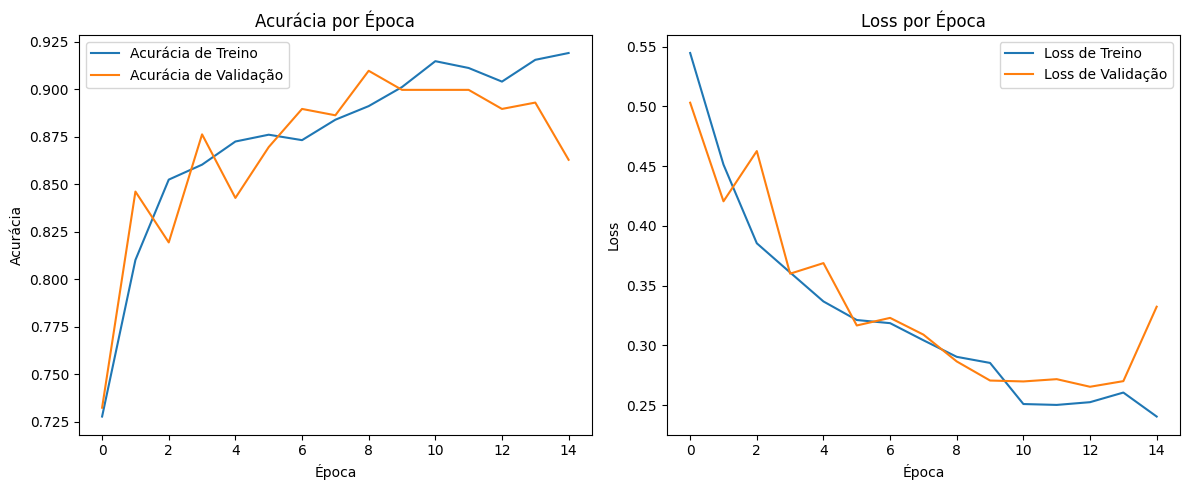

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Acurácia de Treino')
    plt.plot(history['val_acc'], label='Acurácia de Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Loss de Treino')
    plt.plot(history['val_loss'], label='Loss de Validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_transfer)

Para a avaliação do desempenho do modelo, é utilizada uma função que testa o classificador no conjunto de dados de teste, que não foi visto durante o treinamento ou validação.

A função itera sobre o conjunto de teste, coletando as previsões do modelo e os rótulos verdadeiros. Com base nesses dados, duas métricas de avaliação são geradas:

- Relatório de Classificação: Um resumo textual que apresenta métricas chave como precisão, recall e F1-score para cada classe.
- Matriz de Confusão: Uma visualização gráfica que detalha os acertos e erros do modelo, mostrando os verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.

Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.78      0.96      0.86       100
   malignant       0.98      0.86      0.92       200

    accuracy                           0.90       300
   macro avg       0.88      0.91      0.89       300
weighted avg       0.91      0.90      0.90       300



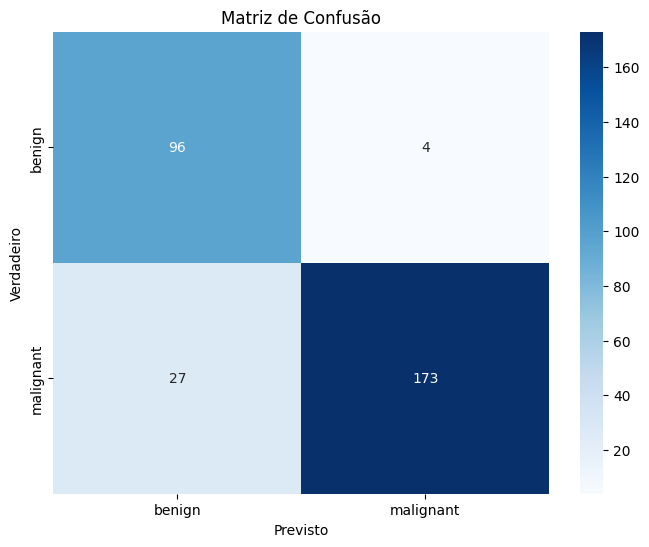

In [ ]:
def avaliar_modelo(modelo, test_loader):
    modelo.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = modelo(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Relatório de Classificação:")
    print(classification_report(all_labels, all_preds, target_names=nomes_classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nomes_classes, yticklabels=nomes_classes)
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.show()

avaliar_modelo(model, test_loader)

## Etapa 5: Otimização com Ajuste Fino (Fine-Tuning)

Com o classificador já treinado, esta etapa avança para o Ajuste Fino (Fine-Tuning), uma técnica para refinar o modelo inteiro e potencialmente aumentar sua performance.

Nesta fase, todas as camadas da rede ResNet-50 são "descongeladas", permitindo que seus pesos sejam atualizados. Um novo otimizador é configurado com uma taxa de aprendizado muito baixa (1e-5). Isso permite que o modelo ajuste sutilmente os pesos pré-treinados, especializando-o ainda mais no dataset BreakHis sem perder o conhecimento generalista adquirido no ImageNet.

O modelo é então treinado por mais algumas épocas com essa nova configuração. O resultado é um modelo final melhor ajustado para a tarefa.

In [ ]:
for param in modelo.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(modelo.parameters(), lr=1e-5)
num_epocas_finetune = 10

model_ft, history_finetune = treinar_modelo(modelo, criterion, optimizer_ft, train_loader, val_loader, num_epochs=num_epocas_finetune)

Época 1/10
----------
Train Loss: 0.2418 Acurácia: 0.9105
Val Loss: 0.2262 Acurácia: 0.9264
Época 2/10
----------
Train Loss: 0.2053 Acurácia: 0.9355
Val Loss: 0.1932 Acurácia: 0.9331
Época 3/10
----------
Train Loss: 0.1803 Acurácia: 0.9441
Val Loss: 0.1787 Acurácia: 0.9431
Época 4/10
----------
Train Loss: 0.1698 Acurácia: 0.9391
Val Loss: 0.1552 Acurácia: 0.9532
Época 5/10
----------
Train Loss: 0.1548 Acurácia: 0.9420
Val Loss: 0.1335 Acurácia: 0.9732
Época 6/10
----------
Train Loss: 0.1405 Acurácia: 0.9513
Val Loss: 0.1303 Acurácia: 0.9532
Época 7/10
----------
Train Loss: 0.1262 Acurácia: 0.9570
Val Loss: 0.1086 Acurácia: 0.9732
Época 8/10
----------
Train Loss: 0.1017 Acurácia: 0.9721
Val Loss: 0.0989 Acurácia: 0.9732
Época 9/10
----------
Train Loss: 0.1039 Acurácia: 0.9642
Val Loss: 0.0813 Acurácia: 0.9866
Época 10/10
----------
Train Loss: 0.1049 Acurácia: 0.9642
Val Loss: 0.0762 Acurácia: 0.9833

Treinamento completo em 6m 57s
Melhor Acurácia de Validação: 0.9866


Avaliação do modelo final após a etapa de Fine-Tuning. A mesma função avaliar_modelo é utilizada sobre o mesmo conjunto de teste para garantir uma comparação justa e consistente. O objetivo é medir o desempenho do modelo totalmente ajustado e verificar se a etapa de fine-tuning resultou em uma melhoria de performance em relação ao modelo treinado apenas no classificador. Os resultados são novamente apresentados através do Relatório de Classificação e da Matriz de Confusão.

Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.95      0.98      0.97       100
   malignant       0.99      0.97      0.98       200

    accuracy                           0.98       300
   macro avg       0.97      0.98      0.97       300
weighted avg       0.98      0.98      0.98       300



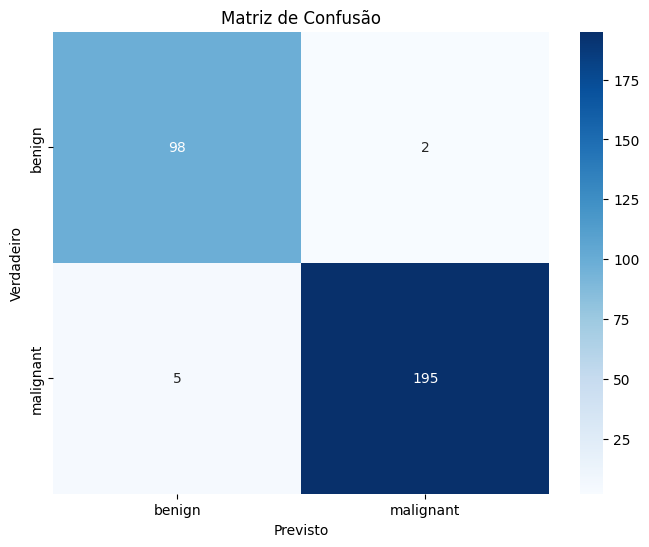

In [ ]:
avaliar_modelo(model_ft, test_loader)

## Etapa 5: Salvamento do Modelo Final

Como etapa final do projeto, o modelo treinado e refinado (após o fine-tuning) é salvo em disco. Especificamente, o state_dict do modelo, que contém todos os seus pesos aprendidos, é exportado para um arquivo com a extensão .pth. Este procedimento garante a persistência do trabalho, permitindo que o modelo seja carregado posteriormente para realizar previsões (inferência) em novos dados, sem a necessidade de executar novamente todo o processo de treinamento.

In [ ]:
final_model_path = 'modelo_final_resnet50_breakhis.pth'
torch.save(model_ft.state_dict(), final_model_path)

print(f"Modelo final salvo em: {final_model_path}")

Modelo final salvo em: modelo_final_resnet50_breakhis.pth
